# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [81]:
import cv2 
import mediapipe as mp # se te corto el audio es verdad 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
#import time
#import threading
#import pyttsx3
from collections import Counter
#from tensorflow.keras.models import load_model

In [82]:
#def speak_async(engine, text):
#    threading.Thread(target=lambda: (engine.say(text), engine.runAndWait())).start()
num_camara=0

## 2. INICIALIZAR MEDIAPIPE

In [83]:
# Inicialización de MediaPipe
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils


pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=1  # Reducir la complejidad
)

hands = mp_hands.Hands(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    max_num_hands=2,
    model_complexity=0  # Complejidad mínima
)

# Variables globales
data_dir = "sign_language_data_JUPYTER"
data_dir_video = "sign_language_data_JUPYTER_videos"
os.makedirs(data_dir, exist_ok=True)
os.makedirs(data_dir_video, exist_ok=True)

sequence_length = 30  # Frames por secuencia
n_pose_landmarks = 33 * 3
n_hand_landmarks = 21 * 3
total_landmarks = n_pose_landmarks + (n_hand_landmarks * 2)

## 3. PROCESAR LOS FRAMES

In [84]:
def process_frame(frame):
    """Procesa un frame y retorna los resultados de pose y manos"""
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pose_results = pose.process(rgb_frame)
    hands_results = hands.process(rgb_frame)
    return pose_results, hands_results

## 4. EXTRAER LOS LANDMARKS

In [85]:
def extract_landmarks(pose_results, hands_results):
    """Extrae y normaliza los landmarks de pose y manos"""
    landmarks = []

    if pose_results.pose_landmarks:
        pose_landmarks = [[lm.x, lm.y, lm.z] for lm in pose_results.pose_landmarks.landmark]
        landmarks.extend(np.array(pose_landmarks).flatten())
    else:
        landmarks.extend([0] * n_pose_landmarks)

    hand_landmarks_list = []
    if hands_results.multi_hand_landmarks:
        for hand_landmarks in hands_results.multi_hand_landmarks[:2]:
            hand_points = [[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]
            hand_landmarks_list.extend(np.array(hand_points).flatten())

    while len(hand_landmarks_list) < n_hand_landmarks * 2:
        hand_landmarks_list.extend([0] * n_hand_landmarks)

    landmarks.extend(hand_landmarks_list)
    return np.array(landmarks)


## 5. RECOLLECION DE DATOS 

In [86]:
def collect_data(data_dir_video, data_dir, sign_name, sequence_length):
    """Recolecta secuencias de movimiento para una seña específica y guarda el video de los landmarks"""
    sign_dir = os.path.join(data_dir, sign_name)
    sign_dir_video = os.path.join(data_dir_video, f"{sign_name}")
    os.makedirs(sign_dir, exist_ok=True)
    os.makedirs(sign_dir_video, exist_ok=True)

    cap = cv2.VideoCapture(num_camara)  # Cambiar índice si usas DroidCam u otra cámara
    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara")
        return

    total_sequences = int(input("Número de secuencias a recolectar (recomendado: 20-30): "))

    print("\nInstrucciones:")
    print(f"1. Cada secuencia grabará {sequence_length} frames de movimiento")
    print("2. Presiona ESPACIO para iniciar cada secuencia")
    print("3. Realiza el movimiento completo de la seña")
    print("4. La grabación se detendrá automáticamente")
    print("5. Presiona ESC para cancelar")

    sequence_count = 0
    frame_count = 0
    is_recording = False
    current_sequence = []

    frame_skip = 1  # Procesar un frame de cada 2
    frame_counter = 0
    video_writer = None

    while sequence_count < total_sequences:
        ret, frame = cap.read()
        if not ret:
            break

        frame_counter += 1
        if frame_counter % frame_skip != 0:
            continue

        frame = cv2.flip(frame, 1)
        blank_frame = np.zeros_like(frame)  # Frame en blanco para los landmarks
        pose_results, hands_results = process_frame(frame)

        # Dibujar los landmarks en un frame en blanco
        if pose_results.pose_landmarks:
            mp_draw.draw_landmarks(blank_frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_draw.draw_landmarks(blank_frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Mostrar mensajes
        if not is_recording:
            cv2.putText(frame, "Presione ESPACIO para grabar secuencia",
                        (10, frame.shape[0] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        else:
            cv2.putText(frame, f"Grabando secuencia... Frame {frame_count}/{sequence_length}",
                        (10, frame.shape[0] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            # Extraer landmarks y guardarlos
            landmarks = extract_landmarks(pose_results, hands_results)
            current_sequence.append(landmarks)
            frame_count += 1

            # Guardar el frame procesado en el video
            if video_writer is not None:
                video_writer.write(blank_frame)

            # Finalizar la secuencia
            if frame_count >= sequence_length:
                sequence_data = np.array(current_sequence)
                np.save(os.path.join(sign_dir, f"sequence_{sequence_count}.npy"), sequence_data)
                print(f"Secuencia {sequence_count + 1}/{total_sequences} guardada")

                sequence_count += 1
                frame_count = 0
                is_recording = False
                current_sequence = []

                # Liberar el escritor de video al finalizar la secuencia
                if video_writer is not None:
                    video_writer.release()
                    video_writer = None

        cv2.putText(frame, f"Secuencias: {sequence_count}/{total_sequences}",
                    (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        resized_frame = cv2.resize(frame, (640, 480))
        cv2.imshow("Recolección de Datos", resized_frame)

        # Mostrar el frame original y de landmarks
        resized_frame = cv2.resize(frame, (640, 480))
        resized_blank_frame = cv2.resize(blank_frame, (640, 480))
        cv2.imshow("Recolección de Datos", resized_frame)
        cv2.imshow("Landmarks", resized_blank_frame)

        key = cv2.waitKey(1) & 0xFF
        if key == 32 and not is_recording:
            is_recording = True
            current_sequence = []
            frame_count = 0
            print(f"\nGrabando secuencia {sequence_count + 1}...")

            # Configurar el escritor de video para la nueva secuencia
            video_file = os.path.join(sign_dir_video, f"sequence_{sequence_count}.avi")
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            video_writer = cv2.VideoWriter(video_file, fourcc, 20.0, (frame.shape[1], frame.shape[0]))
        elif key == 27:
            break

    cap.release()
    if video_writer is not None:
        video_writer.release()
    cv2.destroyAllWindows()
    print(f"\nTotal de secuencias guardadas: {sequence_count}")
    print(f"Ubicación: {sign_dir}")


## 6. ENTRENAMIENTO DEL MODELO

In [87]:
def train_model(data_dir, sequence_length, total_landmarks, model_file):
    """Entrena el modelo utilizando CNN, LSTM y Transformers."""
    
    if not os.listdir(data_dir):
        print("No hay datos para entrenar")
        return

    X = []
    y = []
    class_names = sorted(os.listdir(data_dir))

    print("Cargando secuencias...")
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        samples = [f for f in os.listdir(class_dir) if f.startswith('sequence_')]
        print(f"Clase {class_name}: {len(samples)} secuencias")

        for sample_file in samples:
            sample_path = os.path.join(class_dir, sample_file)
            sequence = np.load(sample_path)
            X.append(sequence)
            y.append(class_idx)

    X = np.array(X)
    y = tf.keras.utils.to_categorical(y)

    # Normalización de los datos
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    # Definir dimensiones del modelo
    input_shape = (sequence_length, total_landmarks)
    num_classes = len(class_names)

    # Arquitectura del modelo
    inputs = tf.keras.Input(shape=input_shape)

    # Bloque CNN para extracción de características espaciales
    cnn = tf.keras.layers.Conv1D(256, kernel_size=3, activation='relu', padding='same')(inputs)
    cnn = tf.keras.layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(cnn)
    cnn = tf.keras.layers.MaxPooling1D(pool_size=2)(cnn)
    cnn = tf.keras.layers.Dropout(0.5)(cnn)

    # Bloque LSTM para modelado temporal a largo plazo
    lstm = tf.keras.layers.LSTM(256, return_sequences=True)(cnn)
    lstm = tf.keras.layers.Dropout(0.5)(lstm)

    # Bloque Transformer para relaciones temporales complejas
    transformer = tf.keras.layers.LayerNormalization()(lstm)
    transformer = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=128)(transformer, transformer)
    transformer = tf.keras.layers.Add()([transformer, lstm])  # Residual connection
    transformer = tf.keras.layers.LayerNormalization()(transformer)
    transformer = tf.keras.layers.Dense(128, activation='relu')(transformer)

    # Capas finales
    global_pool = tf.keras.layers.GlobalAveragePooling1D()(transformer)
    dense = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(global_pool)
    dense = tf.keras.layers.Dropout(0.5)(dense)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(dense)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    

    # Compilar el modelo
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nResumen del modelo:")
    model.summary()

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
        )
    
    print("\nIniciando entrenamiento...")
    history = model.fit(
        X, y,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
        )

    model.save(model_file)
    print(f"\nModelo guardado en {model_file}")

    # Visualización del entrenamiento
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
    plt.title('Precisión del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
    plt.title('Pérdida del Modelo')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

## 7. EVALUACION DEL MODELO

### CARGA DEL MODELO

In [88]:
last_spoken_word = None  # Variable global para almacenar la última palabra pronunciada

def load_model(model_file):
    """Carga el modelo previamente entrenado."""
    if not os.path.exists(model_file):
        print("No se encontró el modelo entrenado")
        return None
    #Cargar el modelo entrenado
    return tf.keras.models.load_model(model_file)

### CARGA DE LA INFORMACION DE PRUEBA

In [89]:
def load_test_data(data_dir, sequence_length):
    """Carga y prepara los datos de prueba."""
    class_names = sorted(os.listdir(data_dir))

    # Crear conjunto de prueba
    print("Cargando datos de prueba...")
    X_test = []
    y_test = []

    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        samples = [f for f in os.listdir(class_dir) if f.startswith('sequence_')]

        # Seleccionar el 20% de las secuencias como prueba
        test_samples = samples[:int(0.2 * len(samples))]
        for sample_file in test_samples:
            sample_path = os.path.join(class_dir, sample_file)
            sequence = np.load(sample_path)
            X_test.append(sequence)
            y_test.append(class_idx)

    X_test = np.array(X_test)
    y_test = tf.keras.utils.to_categorical(y_test)
    return X_test, y_test, class_names

### PRUEBA DEL MODELO

In [90]:
def evaluate_model(model, X_test, y_test):
    """Evalúa el modelo en los datos de prueba."""
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nPérdida en prueba: {loss:.4f}")
    print(f"Precisión en prueba: {accuracy:.2%}")

    # Mostrar métricas globales
    plt.figure(figsize=(6, 4))
    plt.bar(["Pérdida", "Precisión"], [loss, accuracy], color=['blue', 'green'])
    plt.title("Métricas globales en prueba")
    plt.ylim(0, 1)
    plt.ylabel("Valor")
    plt.show()

In [91]:
def preprocess_sequence(sequence):
    """Normaliza una secuencia de landmarks."""
    sequence = np.array(sequence)
    if sequence.size == 0:
        print("Advertencia: Secuencia vacía encontrada.")
        return sequence  # Devuelve la secuencia vacía sin procesar

    mean = np.mean(sequence, axis=0)
    std = np.std(sequence, axis=0)
    std[std == 0] = 1  # Evita divisiones por 0 reemplazando desviaciones estándar de 0 por 1

    return (sequence - mean) / std


In [92]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., 0.])  # Estado inicial
kf.F = np.array([[1., 1.], [0., 1.]])  # Matriz de transición de estado
kf.H = np.array([[1., 0.]])  # Matriz de observación
kf.P *= 1000.  # Covarianza inicial
kf.R = 5  # Ruido de medición
kf.Q = np.array([[0.1, 0.], [0., 0.1]])  # Ruido del proceso

def apply_kalman_filter(prediction):
    kf.predict()
    kf.update(prediction)
    return kf.x[0]

In [93]:
from scipy.signal import savgol_filter

def smooth_landmarks(landmarks, window_length=5, polyorder=2):
    """Suaviza los landmarks usando un filtro Savitzky-Golay."""
    smoothed_landmarks = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length, polyorder),
        axis=0,
        arr=landmarks
    )
    return smoothed_landmarks

### PRUEBA DEL MODELO EN TIEMPO REAL

In [94]:
def evaluate_realtime(model_file, data_dir, sequence_length, mp_draw, mp_pose, mp_hands, num_camara):
    """Realiza la evaluación en tiempo real usando una cámara."""
    model = load_model(model_file)
    if model is None:
        return
    class_names = sorted(os.listdir(data_dir))

    cap = cv2.VideoCapture(num_camara)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

    if not cap.isOpened():
        print("Error: No se pudo abrir la cámara.")
        return

    current_sequence = []
    predictions_buffer = []
    hand_detected = False
    frame_counter = 0

    prediction_confidences = []
    prediction_stabilities = []
    frame_count = 0

    print("\nEvaluando en tiempo real. Presione ESC para salir.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error al capturar el frame.")
            break

        frame_counter += 1
        frame = cv2.flip(frame, 1)
        pose_results, hands_results = process_frame(frame)

        if pose_results.pose_landmarks:
            mp_draw.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            hand_detected = True
        else:
            hand_detected = False

        if hand_detected:
            landmarks = extract_landmarks(pose_results, hands_results)
            if landmarks is not None and len(landmarks) > 0:  # Asegura que no esté vacío
                current_sequence.append(landmarks)

            if len(current_sequence) > sequence_length:
                current_sequence.pop(0)

            if len(current_sequence) == sequence_length:
                # Normalizar la secuencia antes de pasarla al modelo
                sequence_data = np.array([preprocess_sequence(current_sequence)])
                prediction = model.predict(sequence_data, verbose=0)
                predicted_class = class_names[np.argmax(prediction[0])]
                confidence = np.max(prediction[0])

                prediction_confidences.append(confidence)
                predictions_buffer.append(predicted_class)
                if len(predictions_buffer) > 30:  # Buffer más grande
                    predictions_buffer.pop(0)

                from collections import Counter
                most_common = Counter(predictions_buffer).most_common(1)[0]
                stable_prediction = most_common[0]
                stability = most_common[1] / len(predictions_buffer)

                if stability > 0.4 and confidence > 0.6:  # Umbrales más bajos
                    cv2.putText(frame, f"Seña: {stable_prediction}", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                    cv2.putText(frame, f"Confianza: {confidence:.2%}", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        resized_frame = cv2.resize(frame, (640, 480))
        cv2.imshow("Evaluación", resized_frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()

    if prediction_confidences:
        avg_confidence = np.mean(prediction_confidences)
        avg_stability = np.mean(prediction_stabilities)

        print(f"\nPromedio de confianza: {avg_confidence:.2%}")
        print(f"Promedio de estabilidad: {avg_stability:.2%}")

        plt.figure(figsize=(6, 4))
        plt.plot(prediction_confidences, label="Confianza")
        plt.title("Confianza de Predicciones en Tiempo Real")
        plt.xlabel("Frame")
        plt.ylabel("Confianza")
        plt.legend()
        plt.show()

        plt.figure(figsize=(6, 4))
        plt.plot(prediction_stabilities, label="Estabilidad")
        plt.title("Estabilidad de Predicciones en Tiempo Real")
        plt.xlabel("Frame")
        plt.ylabel("Estabilidad")
        plt.legend()
        plt.show()

### EVALUA EL MODELO

In [95]:
def evaluate_on_test_set(model, test_data, class_names):
    """Evalúa el modelo en un conjunto de test y muestra métricas como precisión, recall y F1-score."""
    y_true = []
    y_pred = []

    for sequence, label in test_data:
        sequence_data = np.array([sequence])
        prediction = model.predict(sequence_data, verbose=0)
        predicted_class = np.argmax(prediction[0])

        y_true.append(label)
        y_pred.append(predicted_class)

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicciones")
    plt.ylabel("Reales")
    plt.title("Matriz de Confusión")
    plt.show()


    # Calcular métricas
    from sklearn.metrics import classification_report
    print("\nMétricas del conjunto de test:")
    print(classification_report(y_true, y_pred, target_names=class_names))

## 8. MENU

### DEFINICION

In [96]:
def main():
    #data_dir = "data"  # Directorio para los datos recolectados
    data_dir = "sign_language_data_JUPYTER"
    model_file = "sign_language_model.h5"
    sequence_length = 90  # Longitud de la secuencia para cada muestra
    num_camara = 0  # Índice de la cámara

    # Crear el directorio si no existe
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Ver detección de pose y manos")
        print("2. Recolectar datos de señas")
        print("3. Entrenar modelo")
        print("4. Evaluar en tiempo real")
        print("5. Salir")
        
        option = input("\nSeleccione una opción: ")
        
        if option == "1":
            cap = cv2.VideoCapture(num_camara)
            cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.flip(frame, 1)
                pose_results, hands_results = process_frame(frame)
                # Dibuja los landmarks si se detectan
                if pose_results.pose_landmarks:
                    mp_draw.draw_landmarks(frame, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                
                if hands_results.multi_hand_landmarks:
                    for hand_landmarks in hands_results.multi_hand_landmarks:
                        mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                
                cv2.imshow("Detección de Pose y Manos", frame)

                if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
                    break

            cap.release()
            cv2.destroyAllWindows()
        
        elif option == "2":
            sign_name = input("Nombre de la seña a recolectar: ")
            collect_data(data_dir_video, data_dir, sign_name, sequence_length)
        
        elif option == "3":
            train_model(data_dir, sequence_length, total_landmarks, model_file)
        
        elif option == "4":
            evaluate_realtime(model_file, data_dir, sequence_length, mp_draw, mp_pose, mp_hands, num_camara)
        
        elif option == "5":
            print("¡Hasta luego!")
            break
        
        else:
            print("Opción no válida.")




# MOSTRAR EL MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir

Instrucciones:
1. Cada secuencia grabará 90 frames de movimiento
2. Presiona ESPACIO para iniciar cada secuencia
3. Realiza el movimiento completo de la seña
4. La grabación se detendrá automáticamente
5. Presiona ESC para cancelar

Grabando secuencia 1...
Secuencia 1/30 guardada

Grabando secuencia 2...
Secuencia 2/30 guardada

Grabando secuencia 3...
Secuencia 3/30 guardada

Grabando secuencia 4...
Secuencia 4/30 guardada

Grabando secuencia 5...
Secuencia 5/30 guardada

Grabando secuencia 6...
Secuencia 6/30 guardada

Grabando secuencia 7...
Secuencia 7/30 guardada

Grabando secuencia 8...
Secuencia 8/30 guardada

Grabando secuencia 9...
Secuencia 9/30 guardada

Grabando secuencia 10...
Secuencia 10/30 guardada

Grabando secuencia 11...
Secuencia 11/30 guardada

Grabando secuencia 12...
Secuencia 12/30 guardada



c:\Users\juanp\Desktop\Python\.conda\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


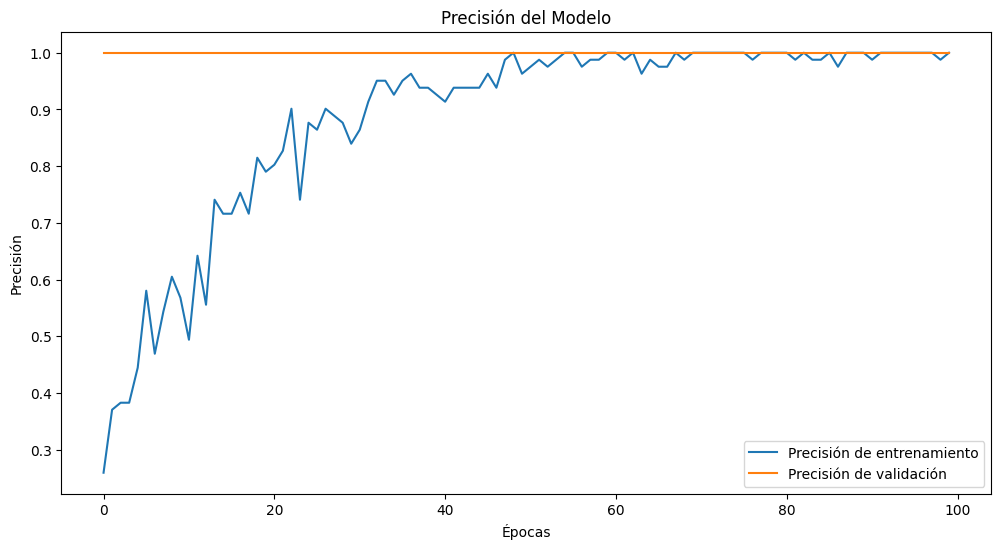

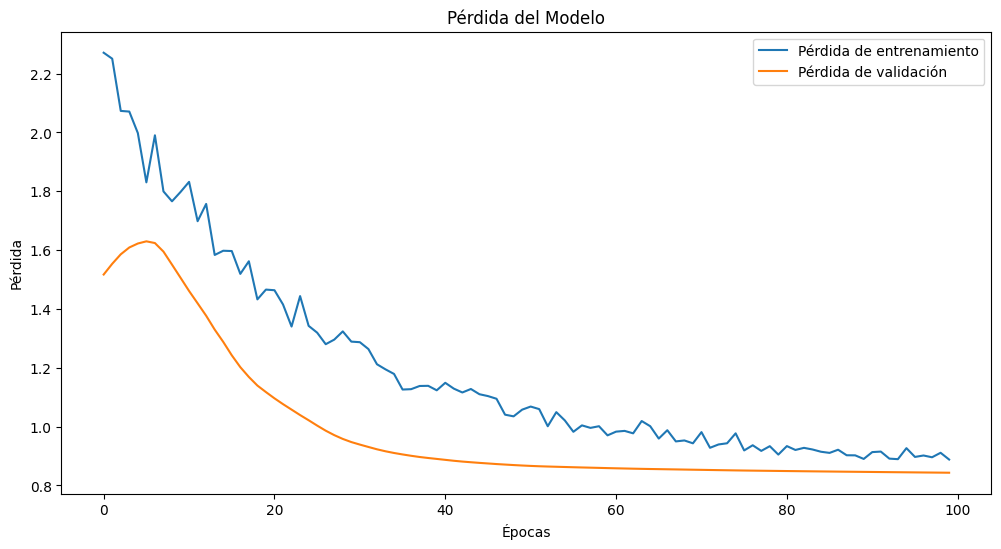


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir

Evaluando en tiempo real. Presione ESC para salir.


c:\Users\juanp\Desktop\Python\.conda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\juanp\Desktop\Python\.conda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Promedio de confianza: 73.71%
Promedio de estabilidad: nan%


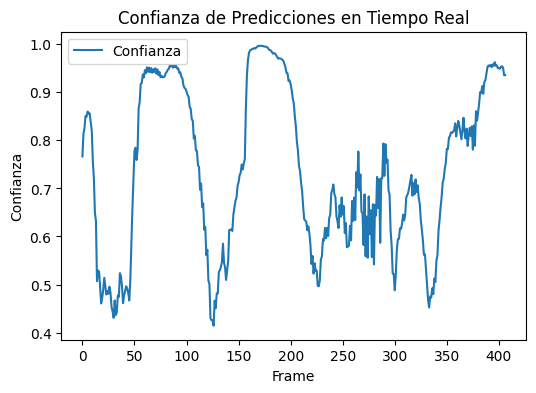

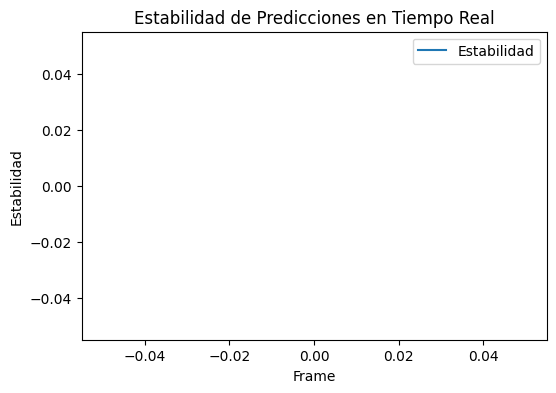


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir
Opción no válida.

=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Ver detección de pose y manos
2. Recolectar datos de señas
3. Entrenar modelo
4. Evaluar en tiempo real
5. Salir
¡Hasta luego!


In [97]:
if __name__ == "__main__":
    main()